In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils

In [3]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

In [4]:
#plt.style.use('ggplot')

In [5]:
class model_result():
    
    def __init__(self, prefix, sigloss, bkgloss, aetype):
        self.sigloss = np.load(prefix+'_'+sigloss+'.npy')
        self.bkgloss = np.load(prefix+'_'+bkgloss+'.npy')
        self.aetype = aetype

        
    def get_tpr_fpr(self):
        bins = np.linspace(0,10000,100001)
        tpr = []
        fpr = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss<cut)[0].shape[0]/len(self.bkgloss))
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss>cut)[0].shape[0]/len(self.bkgloss))
        

        return tpr,fpr
    
    def get_precision_recall(self):
        bins = np.linspace(0,1000,10001)
        tpr = []
        fpr = []
        precision = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss<cut)[0].shape[0])/(np.where(self.bkgloss<cut)[0].shape[0]+np.where(self.sigloss<cut)[0].shape[0]))
            
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss>cut)[0].shape[0])/(np.where(self.bkgloss>cut)[0].shape[0]+np.where(self.sigloss>cut)[0].shape[0]))
        

        return precision,tpr  

    def FPRat95TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs)-1):
            if (tprs[i] < 0.95) and (tprs[i+1] >= 0.95):
                return fprs[i+1]

    def FPRat99TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs) - 1):
            if (tprs[i] < 0.99) and (tprs[i + 1] >= 0.99):
                return fprs[i+1]    

In [6]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(12, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 12)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

# PARAMETER OPTIMIZATION

In [7]:
class model_result(object):
    
    def __init__(self, prefix, aetype):
        self.sigloss = np.load(prefix+'_'+sigloss+'.npy')
        self.bkgloss = np.load(prefix+'_'+bkgloss+'.npy')
        self.aetype = aetype

        
    def get_tpr_fpr(self):
        bins = np.linspace(0,10000,100001)
        tpr = []
        fpr = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss<cut)[0].shape[0]/len(self.bkgloss))
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss>cut)[0].shape[0]/len(self.bkgloss))
        

        return tpr,fpr
    
    def get_precision_recall(self):
        bins = np.linspace(0,1000,10001)
        tpr = []
        fpr = []
        precision = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss<cut)[0].shape[0])/(np.where(self.bkgloss<cut)[0].shape[0]+np.where(self.sigloss<cut)[0].shape[0]))
            
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss>cut)[0].shape[0])/(np.where(self.bkgloss>cut)[0].shape[0]+np.where(self.sigloss>cut)[0].shape[0]))
        

        return precision,tpr  

    def FPRat95TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs)-1):
            if (tprs[i] < 0.95) and (tprs[i+1] >= 0.95):
                return fprs[i+1]

    def FPRat99TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs) - 1):
            if (tprs[i] < 0.99) and (tprs[i + 1] >= 0.99):
                return fprs[i+1]    

In [8]:
version = 0
#zdim = [2,4,6,8,10]
zdim = [4]
#nflow = [2,4,6,8,10]
nflow = [10]
#lrs = [5e-3, 1e-3,5e-4, 1e-4,1e-5,1e-6,1e-7]
betas = [0.1,0.5,1.0,2.0,10.0]

In [9]:
bkg_mean = [229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]

bkg_std = [131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]

# Prepping test dataset

In [10]:
f_bkg = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5')
f_sig = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/delphes_output_4500_500_150.h5')

In [11]:
dt = f_bkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])




idx = dt[:,-1]
bkgidx = (idx == 0)
dt = dt[bkgidx]


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

for i in range(12):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

bkg_test = torch.tensor(Y)

In [12]:
dt = f_sig.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])




correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>100) & (dt[:,19]<200) & (dt[:,0]>4200) & (dt[:,0]<4800)
dt = dt[correct]  


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]




print(Y.shape)
for i in range(12):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

sig_test = torch.tensor(Y)

(26448, 12)


In [13]:
def get_tpr_fpr(sigloss,bkgloss):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))


    return tpr,fpr

In [14]:
import re

In [15]:
tprlist = []
fprlist = []
namelist = []
siglosslist = []
bkglosslist = []
tprlist_forinverse = []
fprinverselist = []
for Z_DIM in zdim:
    for N_FLOWS in nflow:
        for beta in betas:
            model = VAE_NF(N_FLOWS, Z_DIM).cuda()
            ae_def = {
                        "type":"bkg",
                        "trainon":"rndbkg",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
                        "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
                        "version":f"ver{version}"

                     }
            model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}.h5"))
            model.eval()
            sig_loss = torch.mean((model(sig_test.float().cuda())[0]- sig_test.float().cuda())**2,dim=1).data.cpu().numpy()
            bkg_loss = torch.mean((model(bkg_test.float().cuda())[0]- bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()
    
            
            np.save(f"/data/t3home000/spark/QUASAR/data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}_sigloss.npy",sig_loss)
            np.save(f"/data/t3home000/spark/QUASAR/data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}_bkgloss.npy",bkg_loss)
            
            namelist.append(ae_def)
            tpr, fpr = get_tpr_fpr(sig_loss,bkg_loss)
            tprlist.append(tpr)
            fprlist.append(fpr)
            tpr_np, fpr_np = np.array(tpr), np.array(fpr)
            
            nonzero_idx = np.nonzero(fpr_np)
            

            siglosslist.append(sig_loss)
            bkglosslist.append(bkg_loss)
            
            tprlist_forinverse.append(tpr_np[nonzero_idx])
            fprinverselist.append(1/fpr_np[nonzero_idx])
            
            

In [16]:
namelist[0]

{'type': 'bkg',
 'trainon': 'rndbkg',
 'features': '12features',
 'architecture': 'MAF',
 'selection': 'mjjcut',
 'trainloss': 'MSELoss',
 'beta': 'beta0p1',
 'zdimnflow': 'z4f10',
 'version': 'ver0'}

In [17]:
plt.rcParams["figure.figsize"] = (8,8)
from sklearn import metrics

beta0p1_z4f10 18.874836300470843
beta0p5_z4f10 17.622094765635055
beta1p0_z4f10 16.821146423346434
beta2p0_z4f10 19.547755153818066
beta10p0_z4f10 11.208515492580446


(0.0, 1.0)

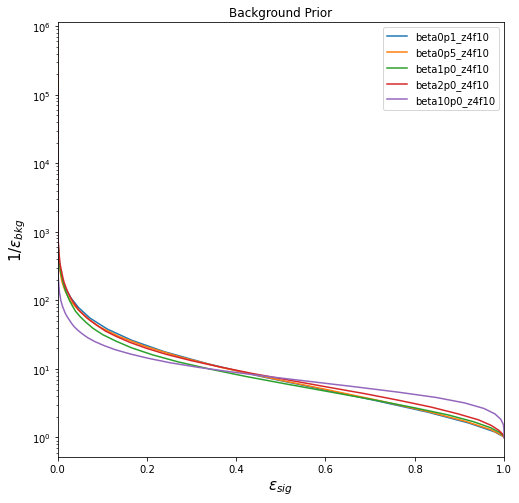

In [18]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist_forinverse,fprinverselist, namelist,siglosslist,bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        #print(tpr, fpr)
        plt.plot(tpr,fpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.yscale('log')

plt.title('Background Prior')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

beta0p1_z4f10 0.7712108444249506
beta0p5_z4f10 0.7754275696089037
beta1p0_z4f10 0.775379037759213
beta2p0_z4f10 0.8024739329172514
beta10p0_z4f10 0.8400540825254872


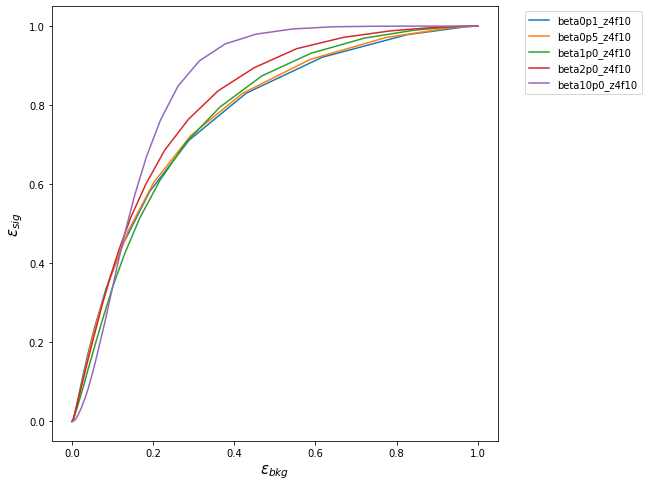

In [19]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist,fprlist, namelist,siglosslist,bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        plt.plot(fpr,tpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.legend(loc='lower right')
#plt.xlim([0.05,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

# NOW SIGNAL AE

In [20]:
f_bkg = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5')
f_sig = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/delphes_output_4500_500_150.h5')

In [21]:
sig_mean = [489.6699791129437,
 0.22463354907052815,
 0.639679230886038,
 0.7742464847783065,
 1.4122267488712905,
 253.95296492556145,
 167.8782919951573,
 0.3429350853771621,
 0.6460772390759577,
 0.7653966882661628,
 1.4541020071952622,
 165.34100428967955]

sig_std = [66.87936517220672,
 0.1361910116638729,
 0.15309413231859276,
 0.10054671892302457,
 0.3833027691949484,
 87.45977372109115,
 50.53622336909848,
 0.14930126292179366,
 0.15096516491915418,
 0.10415175051343364,
 0.44297590229588857,
 55.44436453890166]

In [22]:
dt = f_bkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])




idx = dt[:,-1]
bkgidx = (idx == 0)
dt = dt[bkgidx]


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

for i in range(12):
    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

bkg_test = torch.tensor(Y)

In [23]:
dt = f_sig.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])




correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>100) & (dt[:,19]<200) & (dt[:,0]>4200) & (dt[:,0]<4800)
dt = dt[correct]  


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]




print(Y.shape)
for i in range(12):
    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

sig_test = torch.tensor(Y)

(26448, 12)


In [24]:
def get_tpr_fpr(sigloss,bkgloss):
    bins = np.linspace(0,200,4001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))


    return tpr,fpr

In [25]:
version = 0
#zdim = [2,4,6,8,10]
zdim = [4]
nflow = [2,4,6,8,10]
#lrs = [5e-3, 1e-3,5e-4, 1e-4,1e-5,1e-6,1e-7]
betas = [0.1,0.5,1.0,2.0,10.0]

In [26]:
tprlist = []
fprlist = []
namelist = []
siglosslist = []
bkglosslist = []
tprlist_forinverse = []
fprinverselist = []
for Z_DIM in zdim:
    for N_FLOWS in nflow:
        for beta in betas:
            model = VAE_NF(N_FLOWS, Z_DIM).cuda()
            ae_def = {
                        "type":"sig",
                        "trainon":"2prong",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
                        "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
                        "version":f"ver{version}"

                     }
            model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}.h5"))
            model.eval()
            sig_loss = torch.mean((model(sig_test.float().cuda())[0]- sig_test.float().cuda())**2,dim=1).data.cpu().numpy()
            bkg_loss = torch.mean((model(bkg_test.float().cuda())[0]- bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()
    
            
            np.save(f"/data/t3home000/spark/QUASAR/data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}_sigloss.npy",sig_loss)
            np.save(f"/data/t3home000/spark/QUASAR/data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}_bkgloss.npy",bkg_loss)
            
            namelist.append(ae_def)
            tpr, fpr = get_tpr_fpr(sig_loss,bkg_loss)
            tprlist.append(tpr)
            fprlist.append(fpr)
            tpr_np, fpr_np = np.array(tpr), np.array(fpr)
            
            nonzero_idx = np.nonzero(fpr_np)
            

            siglosslist.append(sig_loss)
            bkglosslist.append(bkg_loss)
            
            tprlist_forinverse.append(tpr_np[nonzero_idx])
            fprinverselist.append(1/fpr_np[nonzero_idx])
            
            

In [27]:
plt.style.use('ggplot')

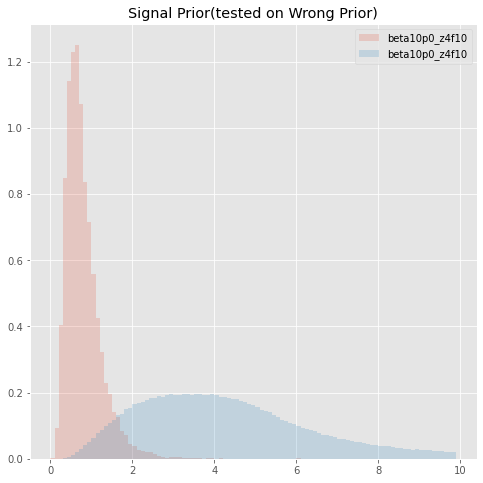

In [28]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist_forinverse,fprinverselist, namelist,siglosslist,bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10' and name['beta'] == 'beta10p0':
        #print(tpr, fpr)
        #plt.plot(tpr,fpr, label=f"{name['beta']}_{name['zdimnflow']}")
        #print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")


plt.title('Signal Prior(tested on Wrong Prior)')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')

#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

beta0p1_z4f10 1530.5950249721568
beta0p5_z4f10 3741.247241989783
beta1p0_z4f10 2600.544791131997
beta2p0_z4f10 3780.481108473225
beta10p0_z4f10 3808.4879842794803


(0.0, 1.0)

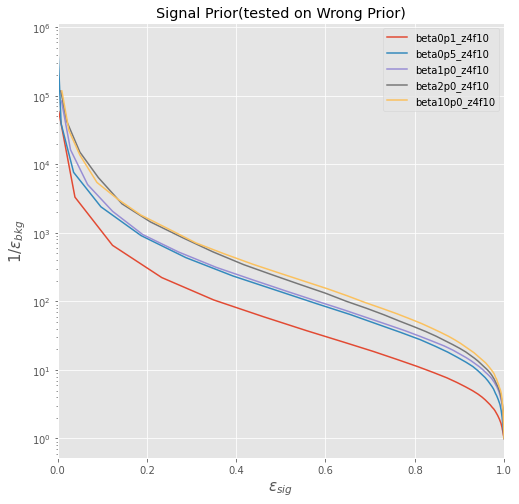

In [29]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist_forinverse,fprinverselist, namelist,siglosslist,bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        #print(tpr, fpr)
        plt.plot(tpr,fpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.yscale('log')

plt.title('Signal Prior(tested on Wrong Prior)')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

# 3 prong signal

In [30]:
f_bkg = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5')
f_sig = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/delphes_output_4500_500_150.h5')

In [31]:
sig_mean = [539.8230906175115,
 0.3093919504152834,
 0.5743852002513076,
 0.7250999951321894,
 1.3980643297136106,
 305.10717416378316,
 417.50598164552935,
 0.3423973996112709,
 0.5859205785605542,
 0.7492831266044925,
 1.6350968023267969,
 261.31617070357555]

sig_std = [104.54956422929888,
 0.12679648500311186,
 0.13543619747203547,
 0.11808533829680096,
 0.34103400809131684,
 100.12586819876644,
 88.97967256083908,
 0.1495063860755517,
 0.14289850921322486,
 0.11224475793826029,
 0.5509216479879365,
 82.84269505360622]

In [32]:
dt = f_bkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])




idx = dt[:,-1]
bkgidx = (idx == 0)
dt = dt[bkgidx]


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

for i in range(12):
    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

bkg_test = torch.tensor(Y)

In [33]:
dt = f_sig.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])




correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>100) & (dt[:,19]<200) & (dt[:,0]>4200) & (dt[:,0]<4800)
dt = dt[correct]  


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]




print(Y.shape)
for i in range(12):
    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

sig_test = torch.tensor(Y)

(26448, 12)


In [34]:
version = 0
#zdim = [2,4,6,8,10]
zdim = [4]
#nflow = [2,4,6,8,10]
nflow = [10]
#lrs = [5e-3, 1e-3,5e-4, 1e-4,1e-5,1e-6,1e-7]
#betas = [0.1,0.5,1.0,2.0,10.0]
betas = [10.0]

In [35]:
import re

In [36]:
tprlist = []
fprlist = []
namelist = []
siglosslist = []
bkglosslist = []
tprlist_forinverse = []
fprinverselist = []
for Z_DIM in zdim:
    for N_FLOWS in nflow:
        for beta in betas:
            model = VAE_NF(N_FLOWS, Z_DIM).cuda()
            ae_def = {
                        "type":"sig",
                        "trainon":"3prong",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
                        "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
                        "version":f"ver{version}"

                     }
            model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}.h5"))
            model.eval()
            sig_loss = torch.mean((model(sig_test.float().cuda())[0]- sig_test.float().cuda())**2,dim=1).data.cpu().numpy()
            bkg_loss = torch.mean((model(bkg_test.float().cuda())[0]- bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()
    
            
            np.save(f"/data/t3home000/spark/QUASAR/data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}_sigloss.npy",sig_loss)
            np.save(f"/data/t3home000/spark/QUASAR/data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}_bkgloss.npy",bkg_loss)
            
            namelist.append(ae_def)
            tpr, fpr = get_tpr_fpr(sig_loss,bkg_loss)
            tprlist.append(tpr)
            fprlist.append(fpr)
            tpr_np, fpr_np = np.array(tpr), np.array(fpr)
            
            nonzero_idx = np.nonzero(fpr_np)
            

            siglosslist.append(sig_loss)
            bkglosslist.append(bkg_loss)
            
            tprlist_forinverse.append(tpr_np[nonzero_idx])
            fprinverselist.append(1/fpr_np[nonzero_idx])
            
            

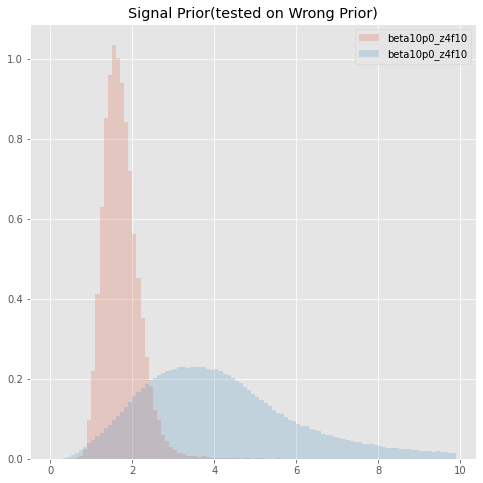

In [37]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist_forinverse,fprinverselist, namelist,siglosslist,bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10' and name['beta'] == 'beta10p0':
        #print(tpr, fpr)
        #plt.plot(tpr,fpr, label=f"{name['beta']}_{name['zdimnflow']}")
        #print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")


plt.title('Signal Prior(tested on Wrong Prior)')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')

#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

beta10p0_z4f10 20.782403465687164


(0.0, 1.0)

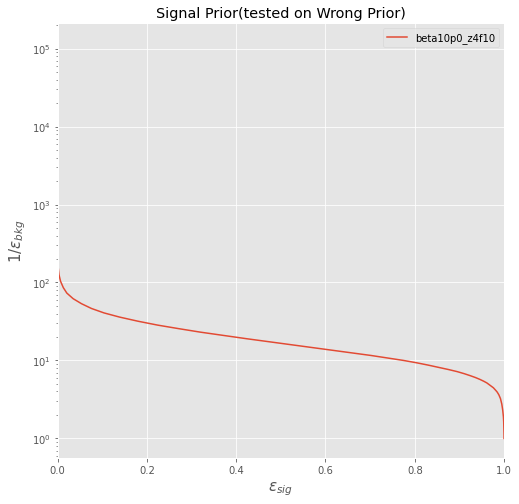

In [38]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist_forinverse,fprinverselist, namelist,siglosslist,bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        #print(tpr, fpr)
        plt.plot(tpr,fpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.yscale('log')

plt.title('Signal Prior(tested on Wrong Prior)')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

# MODEL OPTMIZATION

In [5]:
prong2_prefixes = {
    'mse_5taus_beta1_waic_z6f8':'../data_strings/sigae_2prong_5tausMasRatioNoRawMass_turnonselection_MSELoss_beta1_z6f8_WAICloss',
    'mse_5taus_beta1_just_z6f8':'../data_strings/sigae_2prong_5tausMasRatioNoRawMass_turnonselection_MSELoss_beta1_z6f8_Justloss',
    'mse_cwola_beta1_waic_z6f4':'../data_strings/sigae_2prong_CwolaMassRatioNoRawMass_turnonselection_MSELoss_beta1_z6f4_WAICloss',
    'mse_cwola_beta1_just_z6f4':'../data_strings/sigae_2prong_CwolaMassRatioNoRawMass_turnonselection_MSELoss_beta1_z6f4_Justloss',
    'current':"../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss"
}

In [6]:
bkg_prefixes = {
    
    'waic':'../data_strings/bkg_purebkg_tauDDTwithrawmass_turnoncutandj1sdbcut_MSELoss_beta1_z6f10_WAICloss',
    'just':'../data_strings/bkg_purebkg_tauDDTwithrawmass_turnoncutandj1sdbcut_MSELoss_beta1_z6f10_Justloss',
    'current':'../data_strings/bkg_purebkg_tauDDTwithm1andm1minusm2_turnoncutandj1sdbcut_MSELoss_beta1_z6f10_WAICloss'

    
}

In [7]:
WAIC = model_result(prong2_prefixes['mse_cwola_beta1_waic_z6f4'],'3prong','purebkg','sig')
Justloss = model_result(prong2_prefixes['mse_cwola_beta1_just_z6f4'],'3prong','purebkg','sig')

WAIC5taus = model_result(prong2_prefixes['mse_5taus_beta1_waic_z6f8'],'3prong','purebkg','sig')
Justloss5taus = model_result(prong2_prefixes['mse_5taus_beta1_just_z6f8'],'3prong','purebkg','sig')

trueprior = model_result(prong2_prefixes['mse_cwola_beta1_waic_z6f4'],'2prong','purebkg','sig')
approximateprior = model_result(prong2_prefixes['mse_cwola_beta1_waic_z6f4'],'3prong','purebkg','sig')

In [8]:
WAIC = model_result(bkg_prefixes['waic'],'2prong','purebkg','bkg')
Justloss = model_result(bkg_prefixes['just'],'2prong','purebkg','bkg')

#WAIC5taus = model_result(prong2_prefixes['mse_5taus_beta1_waic_z6f8'],'3prong','purebkg','sig')
#Justloss5taus = model_result(prong2_prefixes['mse_5taus_beta1_just_z6f8'],'3prong','purebkg','sig')

#trueprior = model_result(prong2_prefixes['mse_cwola_beta1_waic_z6f4'],'2prong','purebkg','sig')
#approximateprior = model_result(prong2_prefixes['mse_cwola_beta1_waic_z6f4'],'3prong','purebkg','sig')

In [9]:
correct = model_result(prong2_prefixes['current'],'2prong','purebkg','sig')
wrong = model_result(prong2_prefixes['current'],'3prong','purebkg','sig')
bkgae2 = model_result(bkg_prefixes['current'],'2prong','purebkg','bkg')
bkgae3 = model_result(bkg_prefixes['current'],'3prong','purebkg','bkg')



In [10]:
import mplhep as hep
import mplhep.label as label_base
plt.style.use(hep.style.CMS)

In [11]:
correcttpr, correctfpr = correct.get_tpr_fpr()
wrongtpr, wrongfpr = wrong.get_tpr_fpr()
bkgae2tpr, bkgae2fpr = bkgae2.get_tpr_fpr()
bkgae3tpr, bkgae3fpr = bkgae3.get_tpr_fpr()

In [18]:
def get_tpr_fpr_2d_new(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.linspace(0,10000,10000)
    bins_bkgae = np.linspace(0,50,501)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        compare = -0.1
        tpr_temp = 0
        fpr_temp = 0 
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            if fpr_t == 0:
                fpr_t = 1000000000
            ratio = tpr_t/fpr_t
            if ratio > compare:
                compare = ratio
                tpr_temp = tpr_t
                fpr_temp = fpr_t
        tpr.append(tpr_temp)
        fpr.append(fpr_temp)
                

    return tpr,fpr      

In [19]:
scancorrect_tpr, scancorrect_fpr = get_tpr_fpr_2d_new(correct.sigloss,correct.bkgloss,bkgae2.sigloss,bkgae2.bkgloss)

In [20]:
scanwrong_tpr, scanwrong_fpr = get_tpr_fpr_2d_new(wrong.sigloss,wrong.bkgloss,bkgae3.sigloss,bkgae3.bkgloss)

In [21]:
scanwrong_tpr

[0.0,
 0.00014153029632905793,
 0.0019283502874834144,
 0.0032551968155683326,
 0.0033259619637328614,
 0.0059265811587793015,
 0.0059265811587793015,
 0.0059265811587793015,
 0.0059265811587793015,
 0.00718266253869969,
 0.00718266253869969,
 0.0072003538257408226,
 0.005944272445820433,
 0.0072003538257408226,
 0.0072003538257408226,
 0.0072003538257408226,
 0.0072003538257408226,
 0.0072003538257408226,
 0.0072003538257408226,
 0.0072003538257408226,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.015426802299867315,
 0.0154268022

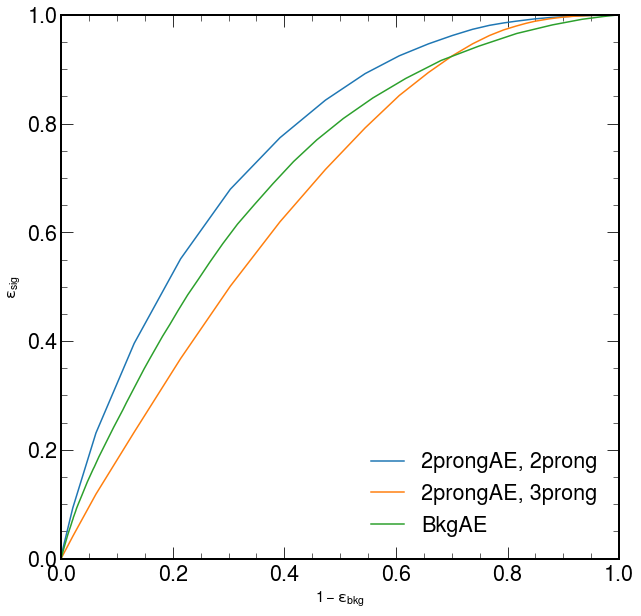

In [23]:
#plt.plot(scancorrect_fpr, scancorrect_tpr ,label = '2Dscan, correct')
#plt.plot(scanwrong_fpr, scanwrong_tpr ,label = '2Dscan, approx')

plt.plot(correctfpr, correcttpr ,label = '2prongAE, 2prong')
#plt.plot(truepriorfpr,truepriortpr,label='MSE')

plt.plot(wrongfpr, wrongtpr ,label = '2prongAE, 3prong')
plt.plot(bkgae2fpr, bkgae2tpr,label = 'BkgAE')
#plt.plot(bkgae3fpr, bkgae3tpr,label = 'BkgAE, 3prong')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_effectiveness_of_quak.png')

In [22]:
#waictpr, waicfpr = WAIC.get_tpr_fpr()
justlosstpr, justlossfpr = Justloss.get_tpr_fpr()

In [21]:
#waictpr5t, waicfpr5t = WAIC5taus.get_tpr_fpr()
justlosstpr5t, justlossfpr5t = Justloss5taus.get_tpr_fpr()

In [48]:
truepriortpr,truepriorfpr = trueprior.get_tpr_fpr()
approxpriortpr, approxpriorfpr = approximateprior.get_tpr_fpr()

NameError: name 'justlossfpr5t' is not defined

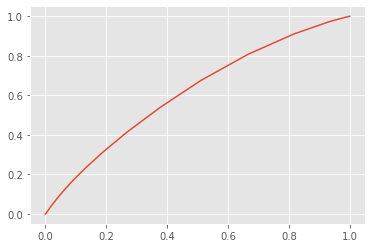

In [13]:
plt.plot(justlossfpr,justlosstpr,label='MSE_cwola')
plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_cwola_vs_5taus.png')

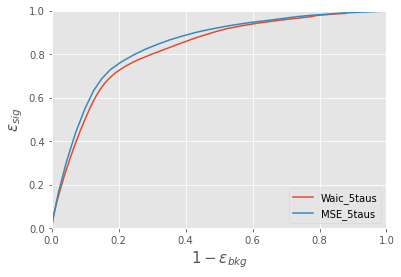

In [23]:
plt.plot(waicfpr5t,waictpr5t,label='Waic_5taus')
plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('ROC_waic_vs_MSE_5taus.png')

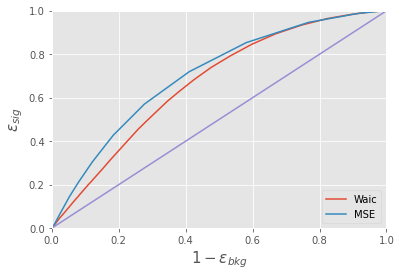

In [24]:
plt.plot(waicfpr,waictpr,label='Waic')
plt.plot(justlossfpr,justlosstpr,label='MSE')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_Waic_vs_Loss_bkg.png')

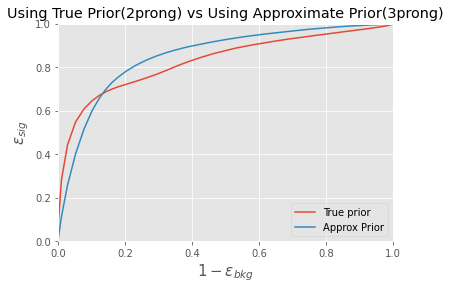

In [35]:
plt.plot(truepriorfpr,truepriortpr,label='True prior')
plt.plot(approxpriorfpr,approxpriortpr,label='Approx Prior')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('Using True Prior(2prong) vs Using Approximate Prior(3prong)')
plt.savefig('ROC_True_vs_Approx.png') 

# HUBER VS MSE LOSS

# varying latent z dim and the number of flows

In [16]:
VAE_bkg = model_result('VanillaVAE__bkgAE','bkg')
VAE_bkg_40var = model_result('VanillaVAE_40var','bkg')
betaVAE_bkg = model_result('BetaVAE_bkgae','bkg')
planarflow_bkg = model_result('NFLOWVAE_PlanarNEW','bkg')
planarflow_bkg22 = model_result('NFLOWVAE_PlanarNEW_22var','bkg')

planarflow_bkg22_z1_f1 = model_result('NFLOWVAE_PlanarNEW_22var_z1_f1','bkg')
planarflow_bkg22_z2_f1 = model_result('NFLOWVAE_PlanarNEW_22var_z2_f1','bkg')
planarflow_bkg22_z3_f1 = model_result('NFLOWVAE_PlanarNEW_22var_z3_f1','bkg')
planarflow_bkg22_z4_f1 = model_result('NFLOWVAE_PlanarNEW_22var_z4_f1','bkg')
planarflow_bkg22_z5_f1 = model_result('NFLOWVAE_PlanarNEW_22var_z5_f1','bkg')

planarflow_bkg22_z1_f2 = model_result('NFLOWVAE_PlanarNEW_22var_z1_f2','bkg')
planarflow_bkg22_z2_f2 = model_result('NFLOWVAE_PlanarNEW_22var_z2_f2','bkg')
planarflow_bkg22_z3_f2 = model_result('NFLOWVAE_PlanarNEW_22var_z3_f2','bkg')
planarflow_bkg22_z4_f2 = model_result('NFLOWVAE_PlanarNEW_22var_z4_f2','bkg')
planarflow_bkg22_z5_f2 = model_result('NFLOWVAE_PlanarNEW_22var_z5_f2','bkg')

planarflow_bkg22_z1_f3 = model_result('NFLOWVAE_PlanarNEW_22var_z1_f3','bkg')
planarflow_bkg22_z2_f3 = model_result('NFLOWVAE_PlanarNEW_22var_z2_f3','bkg')
planarflow_bkg22_z3_f3 = model_result('NFLOWVAE_PlanarNEW_22var_z3_f3','bkg')
planarflow_bkg22_z4_f3 = model_result('NFLOWVAE_PlanarNEW_22var_z4_f3','bkg')
planarflow_bkg22_z5_f3 = model_result('NFLOWVAE_PlanarNEW_22var_z5_f3','bkg')

radialflow_bkg = model_result('NFLOWVAE_Radial','bkg')
maf_bkg = model_result('MAF_bkgae', 'bkg')

In [17]:
prefix = 'supervised_ref_'
ref_tpr = np.load(prefix+'tpr.npy')
ref_fpr = np.load(prefix+'fpr.npy')
ref_precision = np.load(prefix+'precision.npy')
ref_recall = np.load(prefix+'recall.npy')

In [18]:
VAE_bkg_tpr, VAE_bkg_fpr = VAE_bkg.get_tpr_fpr()
VAE_bkg_40var_tpr, VAE_bkg_40var_fpr = VAE_bkg_40var.get_tpr_fpr()
betaVAE_bkg_tpr, betaVAE_bkg_fpr = betaVAE_bkg.get_tpr_fpr()
nflow_bkg_Planar_tpr, nflow_bkg_Planar_fpr = planarflow_bkg.get_tpr_fpr()
nflow_bkg_Planar22_tpr, nflow_bkg_Planar22_fpr = planarflow_bkg22.get_tpr_fpr()

z1f1_tpr, z1f1_fpr = planarflow_bkg22_z1_f1.get_tpr_fpr()
z2f1_tpr, z2f1_fpr = planarflow_bkg22_z2_f1.get_tpr_fpr()
z3f1_tpr, z3f1_fpr = planarflow_bkg22_z3_f1.get_tpr_fpr()
z4f1_tpr, z4f1_fpr = planarflow_bkg22_z4_f1.get_tpr_fpr()
z5f1_tpr, z5f1_fpr = planarflow_bkg22_z5_f1.get_tpr_fpr()

z1f2_tpr, z1f2_fpr = planarflow_bkg22_z1_f2.get_tpr_fpr()
z2f2_tpr, z2f2_fpr = planarflow_bkg22_z2_f2.get_tpr_fpr()
z3f2_tpr, z3f2_fpr = planarflow_bkg22_z3_f2.get_tpr_fpr()
z4f2_tpr, z4f2_fpr = planarflow_bkg22_z4_f2.get_tpr_fpr()
z5f2_tpr, z5f2_fpr = planarflow_bkg22_z5_f2.get_tpr_fpr()

z1f3_tpr, z1f3_fpr = planarflow_bkg22_z1_f3.get_tpr_fpr()
z2f3_tpr, z2f3_fpr = planarflow_bkg22_z2_f3.get_tpr_fpr()
z3f3_tpr, z3f3_fpr = planarflow_bkg22_z3_f3.get_tpr_fpr()
z4f3_tpr, z4f3_fpr = planarflow_bkg22_z4_f3.get_tpr_fpr()
z5f3_tpr, z5f3_fpr = planarflow_bkg22_z5_f3.get_tpr_fpr()



nflow_bkg_Radial_tpr, nflow_bkg_Radial_fpr = radialflow_bkg.get_tpr_fpr()
maf_bkg_tpr, maf_bkg_fpr = maf_bkg.get_tpr_fpr()

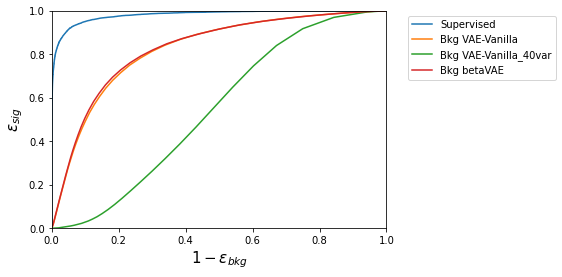

In [19]:
#plt.plot(sig_fpr,sig_tpr,label='Sig Autoencoder trained on complete signal')
#plt.plot(sig_tau21cut_fpr,sig_tau21cut_tpr,label='Sig Autoencoder trained on signal with tau cut')
#plt.plot(bkg_fpr,bkg_tpr,label='Bkg Autoencoder')
plt.plot(ref_fpr,ref_tpr,label='Supervised')
plt.plot(VAE_bkg_fpr,VAE_bkg_tpr,label='Bkg VAE-Vanilla')
plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

#plt.plot(nflow_bkg_Planar_fpr,nflow_bkg_Planar_tpr,label='Bkg NFlowVAE-Planar')
#plt.plot(z1f1_fpr,z1f1_tpr,label='Bkg NFlowVAE-z1_f1')
#plt.plot(z2f1_fpr,z2f1_tpr,label='Bkg NFlowVAE-z2_f1')
#plt.plot(z3f1_fpr,z3f1_tpr,label='Bkg NFlowVAE-z3_f1')
#plt.plot(z4f1_fpr,z4f1_tpr,label='Bkg NFlowVAE-z4_f1')
#plt.plot(z5f1_fpr,z5f1_tpr,label='Bkg NFlowVAE-z5_f1')

#plt.plot(z1f1_fpr,z1f1_tpr,label='Bkg NFlowVAE-z1_f2')
#plt.plot(z2f1_fpr,z2f1_tpr,label='Bkg NFlowVAE-z2_f2')
#plt.plot(z3f1_fpr,z3f1_tpr,label='Bkg NFlowVAE-z3_f2')
#plt.plot(z4f1_fpr,z4f1_tpr,label='Bkg NFlowVAE-z4_f2')
#plt.plot(z5f1_fpr,z5f1_tpr,label='Bkg NFlowVAE-z5_f2')

#plt.plot(z1f1_fpr,z1f1_tpr,label='Bkg NFlowVAE-z1_f3')
#plt.plot(z2f1_fpr,z2f1_tpr,label='Bkg NFlowVAE-z2_f3')
#plt.plot(z3f1_fpr,z3f1_tpr,label='Bkg NFlowVAE-z3_f3')
#plt.plot(z4f1_fpr,z4f1_tpr,label='Bkg NFlowVAE-z4_f3')
#plt.plot(z5f1_fpr,z5f1_tpr,label='Bkg NFlowVAE-z5_f3')

#plt.plot(nflow_bkg_Radial_fpr,nflow_bkg_Radial_tpr,label='Bkg NFlowVAE-Radial')
#plt.plot(maf_bkg_fpr,maf_bkg_tpr,label='Bkg MAF')



#plt.plot(twod_fpr,twod_tpr,'bo',label='AE 2dscan',markersize=2)
#plt.plot(twod_nflowbkg_fpr,twod_nflowbkg_tpr,'bo',label='AE 2dscan',markersize=2,alpha=0.7)
#plt.plot(twod_nflowbkg_tau21sig_fpr, twod_nflowbkg_tau21sig_tpr,'ro',label='2dscan with cut signal',markersize=2,alpha=0.7)
#plt.plot(points[hull1.vertices[2:],0], points[hull1.vertices[2:],1], 'b--', lw=2,label='2dscan with complete signal')
#plt.plot(points2[hull2.vertices[2:],0], points2[hull2.vertices[2:],1], 'r--', lw=2,label='2dscan with incomplete signal')

#plt.plot(fpr,tpr,label='Supervised')
plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_Curve_zdim_fnum.png')

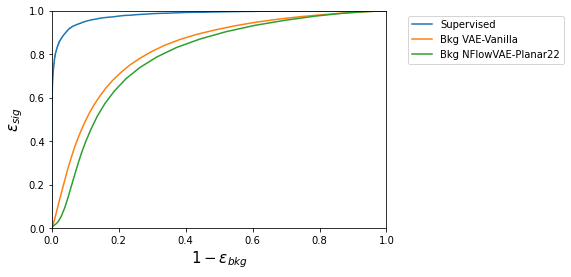

In [34]:
#plt.plot(sig_fpr,sig_tpr,label='Sig Autoencoder trained on complete signal')
#plt.plot(sig_tau21cut_fpr,sig_tau21cut_tpr,label='Sig Autoencoder trained on signal with tau cut')
#plt.plot(bkg_fpr,bkg_tpr,label='Bkg Autoencoder')
plt.plot(ref_fpr,ref_tpr,label='Supervised')
plt.plot(VAE_bkg_fpr,VAE_bkg_tpr,label='Bkg VAE-Vanilla')
#plt.plot(nflow_bkg_Planar_fpr,nflow_bkg_Planar_tpr,label='Bkg NFlowVAE-Planar')
plt.plot(nflow_bkg_Planar22_fpr,nflow_bkg_Planar22_tpr,label='Bkg NFlowVAE-Planar22')

#plt.plot(nflow_bkg_Radial_fpr,nflow_bkg_Radial_tpr,label='Bkg NFlowVAE-Radial')
#plt.plot(maf_bkg_fpr,maf_bkg_tpr,label='Bkg MAF')



#plt.plot(twod_fpr,twod_tpr,'bo',label='AE 2dscan',markersize=2)
#plt.plot(twod_nflowbkg_fpr,twod_nflowbkg_tpr,'bo',label='AE 2dscan',markersize=2,alpha=0.7)
#plt.plot(twod_nflowbkg_tau21sig_fpr, twod_nflowbkg_tau21sig_tpr,'ro',label='2dscan with cut signal',markersize=2,alpha=0.7)
#plt.plot(points[hull1.vertices[2:],0], points[hull1.vertices[2:],1], 'b--', lw=2,label='2dscan with complete signal')
#plt.plot(points2[hull2.vertices[2:],0], points2[hull2.vertices[2:],1], 'r--', lw=2,label='2dscan with incomplete signal')

#plt.plot(fpr,tpr,label='Supervised')
plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_Curve.png')

In [14]:
VAE_bkg_precision, VAE_bkg_recall = VAE_bkg.get_precision_recall()
betaVAE_bkg_precision, betaVAE_bkg_recall = betaVAE_bkg.get_precision_recall()

(0.0, 1.0)

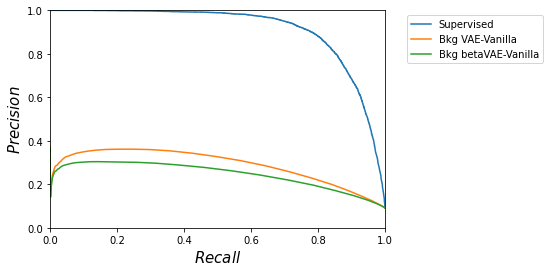

In [15]:
#plt.plot(sig_fpr,sig_tpr,label='Sig Autoencoder trained on complete signal')
#plt.plot(sig_tau21cut_fpr,sig_tau21cut_tpr,label='Sig Autoencoder trained on signal with tau cut')
#plt.plot(bkg_fpr,bkg_tpr,label='Bkg Autoencoder')
plt.plot(ref_recall,ref_precision,label='Supervised')
plt.plot(VAE_bkg_recall,VAE_bkg_precision,label='Bkg VAE-Vanilla')
plt.plot(betaVAE_bkg_recall,betaVAE_bkg_precision,label='Bkg betaVAE-Vanilla')

#plt.plot(nflow_bkg_Planar_recall,nflow_bkg_Planar_precision,label='Bkg NFlowVAE-Planar')
#plt.plot(nflow_bkg_Radial_recall,nflow_bkg_Radial_precision,label='Bkg NFlowVAE-Radial')

#plt.plot(maf_bkg_recall,maf_bkg_precision,label='Bkg MAF')

#plt.plot(twod_fpr,twod_tpr,'bo',label='AE 2dscan',markersize=2)
#plt.plot(twod_nflowbkg_fpr,twod_nflowbkg_tpr,'bo',label='AE 2dscan',markersize=2,alpha=0.7)
#plt.plot(twod_nflowbkg_tau21sig_fpr, twod_nflowbkg_tau21sig_tpr,'ro',label='2dscan with cut signal',markersize=2,alpha=0.7)
#plt.plot(points[hull1.vertices[2:],0], points[hull1.vertices[2:],1], 'b--', lw=2,label='2dscan with complete signal')
#plt.plot(points2[hull2.vertices[2:],0], points2[hull2.vertices[2:],1], 'r--', lw=2,label='2dscan with incomplete signal')

#plt.plot(fpr,tpr,label='Supervised')
plt.xlabel('$Recall$',fontsize=15)
plt.ylabel('$Precision$',fontsize=15)
#plt.semilogy()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
#plt.savefig('PR_Curve_zdim_fnum.png')

In [23]:
VAE_bkg_precision, VAE_bkg_recall = VAE_bkg.get_precision_recall()
nflow_bkg_Planar_precision, nflow_bkg_Planar_recall = planarflow_bkg.get_precision_recall()
nflow_bkg_Radial_precision, nflow_bkg_Radial_recall = radialflow_bkg.get_precision_recall()
maf_bkg_precision, maf_bkg_recall = maf_bkg.get_precision_recall()

In [21]:
z1f1_pre, z1f1_rec = planarflow_bkg22_z1_f1.get_precision_recall()
z2f1_pre, z2f1_rec = planarflow_bkg22_z2_f1.get_precision_recall()
z3f1_pre, z3f1_rec = planarflow_bkg22_z3_f1.get_precision_recall()
z4f1_pre, z4f1_rec = planarflow_bkg22_z4_f1.get_precision_recall()
z5f1_pre, z5f1_rec = planarflow_bkg22_z5_f1.get_precision_recall()

z1f2_pre, z1f2_rec = planarflow_bkg22_z1_f2.get_precision_recall()
z2f2_pre, z2f2_rec = planarflow_bkg22_z2_f2.get_precision_recall()
z3f2_pre, z3f2_rec = planarflow_bkg22_z3_f2.get_precision_recall()
z4f2_pre, z4f2_rec = planarflow_bkg22_z4_f2.get_precision_recall()
z5f2_pre, z5f2_rec = planarflow_bkg22_z5_f2.get_precision_recall()

z1f3_pre, z1f3_rec = planarflow_bkg22_z1_f3.get_precision_recall()
z2f3_pre, z2f3_rec = planarflow_bkg22_z2_f3.get_precision_recall()
z3f3_pre, z3f3_rec = planarflow_bkg22_z3_f3.get_precision_recall()
z4f3_pre, z4f3_rec = planarflow_bkg22_z4_f3.get_precision_recall()
z5f3_pre, z5f3_rec = planarflow_bkg22_z5_f3.get_precision_recall()

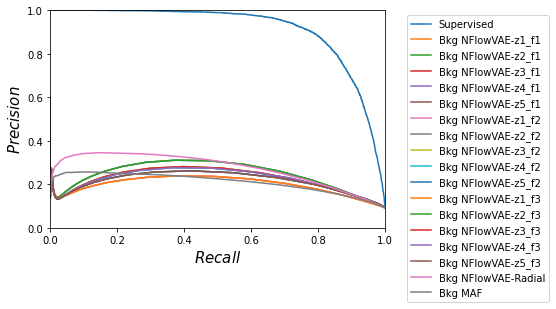

In [26]:
#plt.plot(sig_fpr,sig_tpr,label='Sig Autoencoder trained on complete signal')
#plt.plot(sig_tau21cut_fpr,sig_tau21cut_tpr,label='Sig Autoencoder trained on signal with tau cut')
#plt.plot(bkg_fpr,bkg_tpr,label='Bkg Autoencoder')
plt.plot(ref_recall,ref_precision,label='Supervised')
#plt.plot(VAE_bkg_recall,VAE_bkg_precision,label='Bkg VAE-Vanilla')
#plt.plot(nflow_bkg_Planar_recall,nflow_bkg_Planar_precision,label='Bkg NFlowVAE-Planar')
plt.plot(z1f1_rec,z1f1_pre,label='Bkg NFlowVAE-z1_f1')
plt.plot(z2f1_rec,z2f1_pre,label='Bkg NFlowVAE-z2_f1')
plt.plot(z3f1_rec,z3f1_pre,label='Bkg NFlowVAE-z3_f1')
plt.plot(z4f1_rec,z4f1_pre,label='Bkg NFlowVAE-z4_f1')
plt.plot(z5f1_rec,z5f1_pre,label='Bkg NFlowVAE-z5_f1')

plt.plot(z1f1_rec,z1f1_pre,label='Bkg NFlowVAE-z1_f2')
plt.plot(z2f1_rec,z2f1_pre,label='Bkg NFlowVAE-z2_f2')
plt.plot(z3f1_rec,z3f1_pre,label='Bkg NFlowVAE-z3_f2')
plt.plot(z4f1_rec,z4f1_pre,label='Bkg NFlowVAE-z4_f2')
plt.plot(z5f1_rec,z5f1_pre,label='Bkg NFlowVAE-z5_f2')

plt.plot(z1f1_rec,z1f1_pre,label='Bkg NFlowVAE-z1_f3')
plt.plot(z2f1_rec,z2f1_pre,label='Bkg NFlowVAE-z2_f3')
plt.plot(z3f1_rec,z3f1_pre,label='Bkg NFlowVAE-z3_f3')
plt.plot(z4f1_rec,z4f1_pre,label='Bkg NFlowVAE-z4_f3')
plt.plot(z5f1_rec,z5f1_pre,label='Bkg NFlowVAE-z5_f3')
plt.plot(nflow_bkg_Radial_recall,nflow_bkg_Radial_precision,label='Bkg NFlowVAE-Radial')

plt.plot(maf_bkg_recall,maf_bkg_precision,label='Bkg MAF')

#plt.plot(twod_fpr,twod_tpr,'bo',label='AE 2dscan',markersize=2)
#plt.plot(twod_nflowbkg_fpr,twod_nflowbkg_tpr,'bo',label='AE 2dscan',markersize=2,alpha=0.7)
#plt.plot(twod_nflowbkg_tau21sig_fpr, twod_nflowbkg_tau21sig_tpr,'ro',label='2dscan with cut signal',markersize=2,alpha=0.7)
#plt.plot(points[hull1.vertices[2:],0], points[hull1.vertices[2:],1], 'b--', lw=2,label='2dscan with complete signal')
#plt.plot(points2[hull2.vertices[2:],0], points2[hull2.vertices[2:],1], 'r--', lw=2,label='2dscan with incomplete signal')

#plt.plot(fpr,tpr,label='Supervised')
plt.xlabel('$Recall$',fontsize=15)
plt.ylabel('$Precision$',fontsize=15)
#plt.semilogy()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('PR_Curve_zdim_fnum.png')